# CoLES-demo-multimodal

**In this demo, we will try to show how Multimodal CoLES handles event data of different modalities.**

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os

if not os.path.exists("lightning_logs/CoLES-demo-multimodal"):
    !mkdir -p lightning_logs/CoLES-demo-multimodal
    
if not os.path.exists("CatBoostClassifier"):
    !mkdir -p CatBoostClassifier
    
if not os.path.exists("model"):
    !mkdir -p model

# Libraries

In [4]:
from functools import partial
from datetime import timedelta

import numpy as np
import pandas as pd

import catboost
import umap
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pytorch_lightning as pl
from torch.utils.data.dataloader import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split

from ptls.nn import TrxEncoder
from ptls.nn.seq_encoder.rnn_encoder import RnnEncoder
from ptls.frames import PtlsDataModule 
from ptls.frames.coles import CoLESModule
from ptls.frames.coles.split_strategy import SampleSlices
from ptls.frames.coles.multimodal_dataset import MultiModalDataset
from ptls.frames.coles.multimodal_dataset import MultiModalIterableDataset
from ptls.frames.coles.multimodal_dataset import MultiModalSortTimeSeqEncoderContainer
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceDataset
from ptls.frames.coles.multimodal_inference_dataset import MultiModalInferenceIterableDataset
from ptls.frames.inference_module import InferenceModuleMultimodal
from ptls.data_load.iterable_processing import SeqLenFilter
from ptls.data_load import IterableProcessingDataset
from ptls.data_load.utils import collate_feature_dict
from ptls.data_load.datasets import MemoryMapDataset
from ptls.preprocessing import PandasDataPreprocessor

# Working with data

## Data download

In [5]:
if not os.path.exists("data/transactions.csv"):
    ! mkdir -p data
    ! curl -OL https://storage.yandexcloud.net/ptls-datasets/trans-gender-2019.zip
    ! unzip trans-gender-2019.zip -d data
    ! mv trans-gender-2019.zip data/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 69.3M  100 69.3M    0     0  47.6M      0  0:00:01  0:00:01 --:--:-- 47.6M
Archive:  trans-gender-2019.zip
  inflating: data/gender_test_kaggle_sample_submission.csv  
  inflating: data/gender_train.csv   
  inflating: data/tr_mcc_codes.csv   
  inflating: data/tr_types.csv       
  inflating: data/transactions.csv   


## Data load

In [6]:
data_path = "data/"
! ls $data_path

gender_test_kaggle_sample_submission.csv  tr_types.csv
gender_train.csv			  trans-gender-2019.zip
tr_mcc_codes.csv			  transactions.csv


In [7]:
transactions = pd.read_csv(os.path.join(data_path, "transactions.csv"))
targets = pd.read_csv(os.path.join(data_path, "gender_train.csv"))

We will take one dataset (later we will explain why) of this type.

In [8]:
transactions = transactions.dropna().reset_index(drop=True)
transactions

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id
0,39026145,208 14:18:12,5499,1010,-7254.31,453799
1,39026145,208 14:24:23,5499,1010,-1392.47,453306
2,39026145,209 15:09:16,5499,1010,-2852.31,453306
3,39026145,209 15:13:51,5499,1010,-853.45,058435
4,39026145,209 15:13:17,5499,1010,-1410.44,058435
...,...,...,...,...,...,...
4084146,61870738,453 16:03:02,5499,1010,-5176.84,10217113
4084147,61870738,454 10:54:60,5411,1010,-1652.77,022915
4084148,61870738,454 14:23:59,5499,1010,-4687.23,10217113
4084149,61870738,454 16:11:53,5541,1110,-4491.83,RU570124


Here
1. `customer_id` is the id of some user
2. `tr_datetime` is the time of the transaction
3. `mcc_code` is, in fact, the mcc code of the transaction
4. `tr_type` is the type of transaction (what was paid for)
5. `amount` is the amount of the transaction
6. `term-id` is the id of the terminal where the transaction was carried out

We will predict the gender of the user based on his transactions.

In [9]:
targets

,customer_id,gender
0,10928546,1
1,69348468,1
2,61009479,0
3,74045822,0
4,27979606,1
...,...,...
8395,90417572,0
8396,66837341,0
8397,10758984,1
8398,11376556,0


In [10]:
n_cutomers = len(pd.unique(transactions["customer_id"]))
n_labeling_cutomers = len(pd.unique(targets["customer_id"]))

print("n_cutomers:", n_cutomers)
print("n_labeling_cutomers:", n_labeling_cutomers)

n_cutomers: 14973
n_labeling_cutomers: 8400


As we can see, we do not know the gender of some users. But we don't need it for CoLES-multimodal training! A little later, we will remove\
untagged users to train the classifier, and now we will train CoLES-multimodal on our data

## For example, we will make two "different" datasets from this dataset

In [11]:
list(transactions.columns)

['customer_id', 'tr_datetime', 'mcc_code', 'tr_type', 'amount', 'term_id']

**An important point.** \
Now we are splitting our dataset into two different ones. Let's imagine for easier understanding that sourceA\
and sourceB represent different data modalities.

In [12]:
sourceA = transactions[["customer_id", "tr_datetime", "mcc_code", "term_id"]]
sourceB = transactions[["customer_id", "tr_datetime", "tr_type", "amount"]]

In [13]:
sourceA

,customer_id,tr_datetime,mcc_code,term_id
0,39026145,208 14:18:12,5499,453799
1,39026145,208 14:24:23,5499,453306
2,39026145,209 15:09:16,5499,453306
3,39026145,209 15:13:51,5499,058435
4,39026145,209 15:13:17,5499,058435
...,...,...,...,...
4084146,61870738,453 16:03:02,5499,10217113
4084147,61870738,454 10:54:60,5411,022915
4084148,61870738,454 14:23:59,5499,10217113
4084149,61870738,454 16:11:53,5541,RU570124


In [14]:
sourceB

,customer_id,tr_datetime,tr_type,amount
0,39026145,208 14:18:12,1010,-7254.31
1,39026145,208 14:24:23,1010,-1392.47
2,39026145,209 15:09:16,1010,-2852.31
3,39026145,209 15:13:51,1010,-853.45
4,39026145,209 15:13:17,1010,-1410.44
...,...,...,...,...
4084146,61870738,453 16:03:02,1010,-5176.84
4084147,61870738,454 10:54:60,1010,-1652.77
4084148,61870738,454 14:23:59,1010,-4687.23
4084149,61870738,454 16:11:53,1110,-4491.83


Since we have too perfect a time match in each modality, we will remove random transactions from the first modality\
and random transactions from the second modality, after which we will already have a situation close to the real one.

In [15]:
sourceA_drop_indices = np.random.choice(sourceA.index, 130000, replace=False)
sourceB_drop_indices = np.random.choice(sourceB.index, 420000, replace=False)

sourceA = sourceA.drop(sourceA_drop_indices).reset_index(drop=True)
sourceB = sourceB.drop(sourceB_drop_indices).reset_index(drop=True)

In [16]:
sourceA

,customer_id,tr_datetime,mcc_code,term_id
0,39026145,208 14:18:12,5499,453799
1,39026145,208 14:24:23,5499,453306
2,39026145,209 15:09:16,5499,453306
3,39026145,209 15:13:51,5499,058435
4,39026145,209 15:13:17,5499,058435
...,...,...,...,...
3954146,61870738,452 19:33:04,5541,RU570124
3954147,61870738,453 16:03:02,5499,10217113
3954148,61870738,454 10:54:60,5411,022915
3954149,61870738,454 16:11:53,5541,RU570124


In [17]:
sourceB

,customer_id,tr_datetime,tr_type,amount
0,39026145,208 14:18:12,1010,-7254.31
1,39026145,208 14:24:23,1010,-1392.47
2,39026145,209 15:09:16,1010,-2852.31
3,39026145,209 15:13:51,1010,-853.45
4,39026145,209 15:13:17,1010,-1410.44
...,...,...,...,...
3664146,61870738,452 17:43:16,1010,-7093.72
3664147,61870738,452 19:33:04,1110,-4491.83
3664148,61870738,453 16:03:02,1010,-5176.84
3664149,61870738,454 10:54:60,1010,-1652.77


Now we see that users in SourceA and users in sourceB have a different number of transactions. Moreover, it may\
have happened that some users are present in SourceA, but are absent from sourceB. Multimodal CoLES is able to\
process data with such gaps!

## Preprocessing

In [18]:
mcc_code_in = len(np.unique((sourceA["mcc_code"])))
term_id_in = len(np.unique((sourceA["term_id"])))
tr_type_in = len(np.unique((sourceB["tr_type"])))

print("mcc_code_in:", mcc_code_in)
print("term_id_in:", term_id_in)
print("tr_type_in", tr_type_in)

mcc_code_in: 184
term_id_in: 435131
tr_type_in 73


### tr_datetime column preprocessing

To preprocess the tr_datetime column, we use our own function

In [19]:
def tr_datetime_preprocess(tr_datetime):
    days, hms = tr_datetime.split()
    hh, mm, ss = hms.split(":")
    
    seconds = timedelta(hours=int(hh), minutes=int(mm), seconds=int(ss))
    seconds = seconds.total_seconds()
    seconds += int(days) * 24 * 3600
    
    return int(seconds)

In [20]:
sourceA["tr_datetime"] = sourceA["tr_datetime"].apply(tr_datetime_preprocess)
sourceB["tr_datetime"] = sourceB["tr_datetime"].apply(tr_datetime_preprocess)

### Further preprocessing

Since we processed the tr_datetime column ourselves, we set the `event_time_transformation = "none"`.\
The other parameters are pretty clear.

In [21]:
sourceA_preprocessor = PandasDataPreprocessor(
    col_id="customer_id",
    col_event_time="tr_datetime",
    event_time_transformation="none",
    cols_category=["mcc_code", "term_id"],
    return_records=True,
)

sourceB_preprocessor = PandasDataPreprocessor(
    col_id="customer_id",
    col_event_time="tr_datetime",
    event_time_transformation="none",
    cols_numerical=["tr_type", "amount"],
    return_records=True,
)

In [22]:
processed_sourceA = sourceA_preprocessor.fit_transform(sourceA)
processed_sourceB = sourceB_preprocessor.fit_transform(sourceB)

Now, in order for the model to understand where the data came from, we will add a `source_name` prefix to each data column.\
Note that the customer_id column should not be handled this way.

In [23]:
processed_sourceA_df = pd.DataFrame(processed_sourceA)
processed_sourceA_df.columns = [
    "sourceA_" + str(col) if str(col) != "customer_id" else str(col)
    for col in processed_sourceA_df.columns
]
processed_sourceA_df

,customer_id,sourceA_tr_datetime,sourceA_event_time,sourceA_mcc_code,sourceA_term_id
0,6815,"[tensor(18024490), tensor(18028008), tensor(18...","[tensor(18024490), tensor(18028008), tensor(18...","[tensor(4), tensor(1), tensor(3), tensor(1), t...","[tensor(8), tensor(91629), tensor(194741), ten..."
1,22899,"[tensor(15199293), tensor(17862418), tensor(17...","[tensor(15199293), tensor(17862418), tensor(17...","[tensor(6), tensor(7), tensor(6), tensor(6), t...","[tensor(42683), tensor(187932), tensor(42683),..."
2,27914,"[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(1), tensor(4), tensor(1), tensor(4), t...","[tensor(5795), tensor(5795), tensor(5795), ten..."
3,28753,"[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(4), tensor(2), tensor(4), tensor(3), t...","[tensor(27), tensor(5), tensor(23), tensor(206..."
4,31385,"[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(3), tensor(3), tensor(3), tensor(1), t...","[tensor(123599), tensor(374307), tensor(160138..."
...,...,...,...,...,...
14967,99984336,"[tensor(18784661), tensor(18784675), tensor(19...","[tensor(18784661), tensor(18784675), tensor(19...","[tensor(1), tensor(1), tensor(2), tensor(3), t...","[tensor(26162), tensor(26162), tensor(3), tens..."
14968,99985917,"[tensor(27694066), tensor(34521366), tensor(36...","[tensor(27694066), tensor(34521366), tensor(36...","[tensor(4), tensor(1), tensor(3)]","[tensor(204774), tensor(252723), tensor(129630)]"
14969,99988578,"[tensor(17867127), tensor(18037970), tensor(18...","[tensor(17867127), tensor(18037970), tensor(18...","[tensor(6), tensor(3), tensor(2), tensor(2), t...","[tensor(61149), tensor(197618), tensor(2), ten..."
14970,99991245,"[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(6), tensor(6), tensor(1), tensor(1), t...","[tensor(18317), tensor(322494), tensor(60033),..."


In [24]:
processed_sourceB_df = pd.DataFrame(processed_sourceB)
processed_sourceB_df.columns = [
    "sourceB_" + str(col) if str(col) != "customer_id" else str(col)
    for col in processed_sourceB_df.columns
]
processed_sourceB_df

,customer_id,sourceB_tr_datetime,sourceB_event_time,sourceB_tr_type,sourceB_amount
0,6815,"[tensor(18024490), tensor(18198405), tensor(18...","[tensor(18024490), tensor(18198405), tensor(18...","[tensor(1030), tensor(1110), tensor(2010), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
1,22899,"[tensor(15199293), tensor(17869914), tensor(18...","[tensor(15199293), tensor(17869914), tensor(18...","[tensor(1110), tensor(1110), tensor(1110), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
2,27914,"[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(7010), tensor(1030), tensor(7010), ten...","[tensor(6737.7500, dtype=torch.float64), tenso..."
3,28753,"[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(1030), tensor(7070), tensor(1030), ten...","[tensor(-8983.6600, dtype=torch.float64), tens..."
4,31385,"[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(1010), tensor(1110), tensor(1110), ten...","[tensor(-6636.2300, dtype=torch.float64), tens..."
...,...,...,...,...,...
14966,99984336,"[tensor(18784661), tensor(18784675), tensor(19...","[tensor(18784661), tensor(18784675), tensor(19...","[tensor(4010), tensor(2010), tensor(7070), ten...","[tensor(-12127.9500, dtype=torch.float64), ten..."
14967,99985917,"[tensor(19744592), tensor(34521366), tensor(36...","[tensor(19744592), tensor(34521366), tensor(36...","[tensor(2010), tensor(7010), tensor(1010)]","[tensor(-11229.5800, dtype=torch.float64), ten..."
14968,99988578,"[tensor(18037970), tensor(18039431), tensor(18...","[tensor(18037970), tensor(18039431), tensor(18...","[tensor(1010), tensor(7071), tensor(7071), ten...","[tensor(-4783.8000, dtype=torch.float64), tens..."
14969,99991245,"[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(1010), tensor(1010), tensor(7010), ten...","[tensor(-14351.4000, dtype=torch.float64), ten..."


Now we have prepared datasets in which each feature has the prefix source<A/B> and for further training of the model,\
we need to merge these two datasets into one large dataset. We will merge them according to the "customer_id" column

> **NOTE** \
> **We can see that the total number of users in the first dataset differs from the total number of users in the second dataset.** \
> **In order for our model to process these users correctly, we first merge the datasets so that these users are not lost (let's do \
> `df.merge(...)` with `how="outer"`), and then, in order for the model to understand the data, we will replace `NaN` with `torch.tensor([])`**

In [25]:
joined_data = processed_sourceA_df.merge(processed_sourceB_df, how="outer", on="customer_id")
joined_data

,customer_id,sourceA_tr_datetime,sourceA_event_time,sourceA_mcc_code,sourceA_term_id,sourceB_tr_datetime,sourceB_event_time,sourceB_tr_type,sourceB_amount
0,6815,"[tensor(18024490), tensor(18028008), tensor(18...","[tensor(18024490), tensor(18028008), tensor(18...","[tensor(4), tensor(1), tensor(3), tensor(1), t...","[tensor(8), tensor(91629), tensor(194741), ten...","[tensor(18024490), tensor(18198405), tensor(18...","[tensor(18024490), tensor(18198405), tensor(18...","[tensor(1030), tensor(1110), tensor(2010), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
1,22899,"[tensor(15199293), tensor(17862418), tensor(17...","[tensor(15199293), tensor(17862418), tensor(17...","[tensor(6), tensor(7), tensor(6), tensor(6), t...","[tensor(42683), tensor(187932), tensor(42683),...","[tensor(15199293), tensor(17869914), tensor(18...","[tensor(15199293), tensor(17869914), tensor(18...","[tensor(1110), tensor(1110), tensor(1110), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
2,27914,"[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(1), tensor(4), tensor(1), tensor(4), t...","[tensor(5795), tensor(5795), tensor(5795), ten...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(7010), tensor(1030), tensor(7010), ten...","[tensor(6737.7500, dtype=torch.float64), tenso..."
3,28753,"[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(4), tensor(2), tensor(4), tensor(3), t...","[tensor(27), tensor(5), tensor(23), tensor(206...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(1030), tensor(7070), tensor(1030), ten...","[tensor(-8983.6600, dtype=torch.float64), tens..."
4,31385,"[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(3), tensor(3), tensor(3), tensor(1), t...","[tensor(123599), tensor(374307), tensor(160138...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(1010), tensor(1110), tensor(1110), ten...","[tensor(-6636.2300, dtype=torch.float64), tens..."
...,...,...,...,...,...,...,...,...,...
14968,99985917,"[tensor(27694066), tensor(34521366), tensor(36...","[tensor(27694066), tensor(34521366), tensor(36...","[tensor(4), tensor(1), tensor(3)]","[tensor(204774), tensor(252723), tensor(129630)]","[tensor(19744592), tensor(34521366), tensor(36...","[tensor(19744592), tensor(34521366), tensor(36...","[tensor(2010), tensor(7010), tensor(1010)]","[tensor(-11229.5800, dtype=torch.float64), ten..."
14969,99988578,"[tensor(17867127), tensor(18037970), tensor(18...","[tensor(17867127), tensor(18037970), tensor(18...","[tensor(6), tensor(3), tensor(2), tensor(2), t...","[tensor(61149), tensor(197618), tensor(2), ten...","[tensor(18037970), tensor(18039431), tensor(18...","[tensor(18037970), tensor(18039431), tensor(18...","[tensor(1010), tensor(7071), tensor(7071), ten...","[tensor(-4783.8000, dtype=torch.float64), tens..."
14970,99991245,"[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(6), tensor(6), tensor(1), tensor(1), t...","[tensor(18317), tensor(322494), tensor(60033),...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(1010), tensor(1010), tensor(7010), ten...","[tensor(-14351.4000, dtype=torch.float64), ten..."
14971,99999680,"[tensor(18099052), tensor(18231992), tensor(18...","[tensor(18099052), tensor(18231992), tensor(18...","[tensor(1), tensor(4), tensor(2), tensor(4), t...","[tensor(34830), tensor(10), tensor(6), tensor(...","[tensor(18231992), tensor(18263400), tensor(18...","[tensor(18231992), tensor(18263400), tensor(18...","[tensor(1030), tensor(7070), tensor(7030), ten...","[tensor(-2470.5100, dtype=torch.float

In [28]:
joined_data = joined_data.applymap(lambda x: torch.tensor([]) if pd.isna(x) else x)
joined_data

,customer_id,sourceA_tr_datetime,sourceA_event_time,sourceA_mcc_code,sourceA_term_id,sourceB_tr_datetime,sourceB_event_time,sourceB_tr_type,sourceB_amount
0,6815,"[tensor(18024490), tensor(18028008), tensor(18...","[tensor(18024490), tensor(18028008), tensor(18...","[tensor(4), tensor(1), tensor(3), tensor(1), t...","[tensor(8), tensor(91629), tensor(194741), ten...","[tensor(18024490), tensor(18198405), tensor(18...","[tensor(18024490), tensor(18198405), tensor(18...","[tensor(1030), tensor(1110), tensor(2010), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
1,22899,"[tensor(15199293), tensor(17862418), tensor(17...","[tensor(15199293), tensor(17862418), tensor(17...","[tensor(6), tensor(7), tensor(6), tensor(6), t...","[tensor(42683), tensor(187932), tensor(42683),...","[tensor(15199293), tensor(17869914), tensor(18...","[tensor(15199293), tensor(17869914), tensor(18...","[tensor(1110), tensor(1110), tensor(1110), ten...","[tensor(-2245.9200, dtype=torch.float64), tens..."
2,27914,"[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(1), tensor(4), tensor(1), tensor(4), t...","[tensor(5795), tensor(5795), tensor(5795), ten...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(20795643), tensor(20795989), tensor(20...","[tensor(7010), tensor(1030), tensor(7010), ten...","[tensor(6737.7500, dtype=torch.float64), tenso..."
3,28753,"[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(4), tensor(2), tensor(4), tensor(3), t...","[tensor(27), tensor(5), tensor(23), tensor(206...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(18435883), tensor(18767232), tensor(20...","[tensor(1030), tensor(7070), tensor(1030), ten...","[tensor(-8983.6600, dtype=torch.float64), tens..."
4,31385,"[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(3), tensor(3), tensor(3), tensor(1), t...","[tensor(123599), tensor(374307), tensor(160138...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(17916145), tensor(17944106), tensor(18...","[tensor(1010), tensor(1110), tensor(1110), ten...","[tensor(-6636.2300, dtype=torch.float64), tens..."
...,...,...,...,...,...,...,...,...,...
14968,99985917,"[tensor(27694066), tensor(34521366), tensor(36...","[tensor(27694066), tensor(34521366), tensor(36...","[tensor(4), tensor(1), tensor(3)]","[tensor(204774), tensor(252723), tensor(129630)]","[tensor(19744592), tensor(34521366), tensor(36...","[tensor(19744592), tensor(34521366), tensor(36...","[tensor(2010), tensor(7010), tensor(1010)]","[tensor(-11229.5800, dtype=torch.float64), ten..."
14969,99988578,"[tensor(17867127), tensor(18037970), tensor(18...","[tensor(17867127), tensor(18037970), tensor(18...","[tensor(6), tensor(3), tensor(2), tensor(2), t...","[tensor(61149), tensor(197618), tensor(2), ten...","[tensor(18037970), tensor(18039431), tensor(18...","[tensor(18037970), tensor(18039431), tensor(18...","[tensor(1010), tensor(7071), tensor(7071), ten...","[tensor(-4783.8000, dtype=torch.float64), tens..."
14970,99991245,"[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(6), tensor(6), tensor(1), tensor(1), t...","[tensor(18317), tensor(322494), tensor(60033),...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(18270717), tensor(18430268), tensor(18...","[tensor(1010), tensor(1010), tensor(7010), ten...","[tensor(-14351.4000, dtype=torch.float64), ten..."
14971,99999680,"[tensor(18099052), tensor(18231992), tensor(18...","[tensor(18099052), tensor(18231992), tensor(18...","[tensor(1), tensor(4), tensor(2), tensor(4), t...","[tensor(34830), tensor(10), tensor(6), tensor(...","[tensor(18231992), tensor(18263400), tensor(18...","[tensor(18231992), tensor(18263400), tensor(18...","[tensor(1030), tensor(7070), tensor(7030), ten...","[tensor(-2470.5100, dtype=torch.float

### train_test_split!

In [29]:
train_df, test_df = train_test_split(joined_data,
                                     test_size=0.4,
                                     random_state=42)
train_df, valid_df = train_test_split(train_df,
                                      test_size=0.1,
                                      random_state=42)

In [30]:
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

### Now we need to change the dataset type to `MultiModalIterableDataset`

The model accepts the `dict` data type, so we convert our dataframe

In [31]:
train_dict = train_df.to_dict("records")
valid_dict = valid_df.to_dict("records")
test_dict = test_df.to_dict("records")

We need to show our model where the features came from.

In [32]:
source_features = {
    "sourceA": ["event_time", "mcc_code", "term_id"],
    "sourceB": ["event_time", "tr_type", "amount"]
}

In [33]:
splitter = SampleSlices(split_count=5, cnt_min=25, cnt_max=50)

In [34]:
train_multimodal_data = MultiModalIterableDataset(
    data = train_dict,
    splitter = splitter,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

valid_multimodal_data = MultiModalIterableDataset(
    data = valid_dict,
    splitter = splitter,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

### Finally, we create a dataloader

In [35]:
train_loader = PtlsDataModule(
    train_data = train_multimodal_data,
    train_num_workers = 16,
    train_batch_size = 64,
    
    valid_data = valid_multimodal_data
)

# Model

## The model consists of several parts
1. TrxEncoder for each modality source<A/B>
2. SeqEncoder (RNN encoder) to combine both modalities and one embedding

### Specify the TrxEncoder parameters for each of the modalities

In [36]:
sourceA_encoder_params = dict(
    embeddings_noise = 0.003,
    linear_projection_size = 64,
    embeddings = {
        "mcc_code": {"in": mcc_code_in, "out": 32},
        "term_id": {"in": term_id_in, "out": 32}
    },
)

sourceB_encoder_params = dict(
    embeddings_noise = 0.003,
    linear_projection_size = 64,
    embeddings = {
        "tr_type": {"in": tr_type_in, "out": 32},
    },
    numeric_values = {"amount": "identity"},
)

### Finally, making TrxEncoders

In [37]:
sourceA_encoder = TrxEncoder(**sourceA_encoder_params)
sourceB_encoder = TrxEncoder(**sourceB_encoder_params)

### Now we are creating a SeqEncoder, it will combine our two TrxEncoders

In [38]:
seq_encoder = MultiModalSortTimeSeqEncoderContainer(
    trx_encoders = {
        "sourceA": sourceA_encoder,
        "sourceB": sourceB_encoder,
    },
    
    input_size = 64,
    hidden_size = 256,
    seq_encoder_cls = RnnEncoder,
    type = "gru"
)

## As a result, our model is a CoLESModule, which has a SeqEncoder, optimizer and lr_scheduller under the hood

In [39]:
model = CoLESModule(
    seq_encoder = seq_encoder,
    optimizer_partial = partial(torch.optim.Adam, lr=0.004),
    lr_scheduler_partial = partial(torch.optim.lr_scheduler.StepLR, step_size=30, gamma=0.5)
)

In [40]:
# model.load_state_dict(torch.load("model/multimodal_coles.pt"))

# Training model

In [41]:
logger = TensorBoardLogger("lightning_logs", name="CoLES-demo-multimodal")

pl_trainer = pl.Trainer(
    logger = logger,
    max_epochs = 8,
    accelerator = "gpu",
    devices = 1,
    enable_progress_bar = True
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [60]:
# If you don't have the progress-bar widget displayed in pl.Trainer(), try this
# !python -m pip3 install ipywidgets=7.7.2 

In [42]:
pl_trainer.fit(model, train_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type                                  | Params
-----------------------------------------------------------------------------
0 | _loss              | ContrastiveLoss                       | 0     
1 | _seq_encoder       | MultiModalSortTimeSeqEncoderContainer | 14.2 M
2 | _validation_metric | BatchRecallTopK                       | 0     
3 | _head              | Head                                  | 0     
-----------------------------------------------------------------------------
14.2 M    Trainable params
0         Non-trainable params
14.2 M    Total params
56.745    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [43]:
torch.save(model.state_dict(), "model/multimodal_coles.pt")

# Getting embeddings

Now we take the embeddings out of our model to perform some kind of downstream task.

## We will get embedding from the test_data

Initially, we divided our dataset into train and test. We trained on a train sample, so we will only informatively test embeddings\
on a test sample. We will train the classifier and see how well it predicts gender. We will also train and test the classifier on\
those embeddings that correspond to the test sample

### To begin with, we will prepare the data for receiving embeddings

In [44]:
inf_test_data = MultiModalInferenceIterableDataset(
    data = test_dict,
    source_features = source_features,
    col_id = "customer_id",
    col_time = "event_time",
    source_names = ("sourceA", "sourceB")
)

In [48]:
inf_test_loader = DataLoader(
    dataset = inf_test_data,
    collate_fn = partial(inf_test_data.collate_fn, col_id="customer_id"),
    shuffle = False,
    num_workers = 0,
    batch_size = 8
)

### For getting embeddings we use `InferenceModuleMultimodal`

In [49]:
inference_module = InferenceModuleMultimodal(
    model = model,
    pandas_output = True,
    drop_seq_features = True,
    model_out_name = 'emb',
    col_id = 'customer_id'
)

inference_module.model.is_reduce_sequence = True

### Finally, getting embeddings

In [50]:
inf_test_embeddings = pd.concat(
    pl_trainer.predict(inference_module, inf_test_loader),
    axis = 0
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 127it [00:00, ?it/s]

In [51]:
inf_test_embeddings

,customer_id,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,...,emb_0246,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255
0,78025217,0.413746,0.858869,-0.677708,-0.017321,-0.017456,0.014926,0.677917,-0.415550,-0.005297,...,0.999459,0.990193,-0.090419,-0.996863,-0.009046,0.286223,0.286304,-0.049703,-0.935602,0.074009
1,65956325,0.492977,0.528077,-0.610989,-0.016784,-0.002500,0.018256,0.099529,-0.410745,-0.006034,...,0.957604,0.937828,-0.088500,-0.752469,-0.008976,0.270881,0.287199,-0.029457,-0.786187,-0.564369
2,66311481,0.293431,0.790296,-0.665110,-0.016481,-0.022149,0.019654,0.364096,-0.582253,0.000258,...,0.991701,0.932593,-0.115112,-0.888719,-0.015846,0.279965,0.278412,-0.044693,-0.507652,-0.528927
3,38129216,0.505099,0.969722,-0.673720,-0.018966,-0.012041,0.050391,0.941543,-0.347281,-0.003878,...,0.999706,0.992380,-0.088612,-0.995542,-0.013593,0.108559,0.278006,-0.054269,-0.882862,0.508139
4,47984117,0.600270,0.829427,-0.592149,-0.017993,-0.008383,0.014914,0.705236,-0.533868,-0.000714,...,0.999269,0.987388,-0.087689,-0.993074,-0.011641,0.249356,0.294167,-0.039023,-0.861534,-0.772475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,53930440,0.501363,0.569685,-0.660863,-0.020365,-0.010839,0.016316,0.220919,-0.416980,-0.005359,...,0.905999,0.923571,-0.086789,-0.700663,-0.008720,0.310029,0.281555,-0.032735,-0.734168,-0.234203
2,54980632,0.335079,0.828794,-0.626111,-0.098174,-0.008514,0.014733,0.636661,-0.438482,-0.041508,...,0.999395,0.985646,-0.093596,-0.992726,-0.013255,0.218430,0.287609,-0.026895,-0.969076,0.279923
3,87655247,0.398965,0.909230,-0.974391,-0.016631,-0.010812,0.018865,0.594259,-0.548459,-0.008713,...,0.998234,0.973626,-0.095115,-0.952786,-0.004265,0.279442,0.286616,-0.028524,-0.905594,-0.554877
4,95861431,0.635102,0.696272,-0.684941,-0.016915,-0.019670,0.016554,0.739321,-0.355432,0.024886,...,0.991218,0.921598,-0.080135,-0.989664,-0.009955,0.279922,0.295039,-0.068442,-0.875616,0.658931


# Another preparing [and visualizing] data

Now we will try to visualize exactly what our embeddings look like when projected onto a 2D space.

In [52]:
def show_2d_emb(reduced_embeddings, targets=None):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x = reduced_embeddings[:, 0],
                    y = reduced_embeddings[:, 1],
                    hue = targets,
                    palette = 'viridis')
    plt.title('UMAP 2D features')
    plt.show()

Now is the time to reduce the data a bit. At the very beginning, we said that some of our users are untagged, we trained Multimodal CoLES\
on untagged data, but to check the quality of classification, we need marked data. That is why now we will merge our embeddings and targets\
so that the untagged data goes away and only those users for whom we know the gender remain.

In [53]:
targets_df = targets.set_index("customer_id")
inf_test_df = inf_test_embeddings.merge(targets_df, how='inner', on='customer_id')
inf_test_df = inf_test_df.set_index("customer_id")
inf_test_df

,emb_0000,emb_0001,emb_0002,emb_0003,emb_0004,emb_0005,emb_0006,emb_0007,emb_0008,emb_0009,...,emb_0247,emb_0248,emb_0249,emb_0250,emb_0251,emb_0252,emb_0253,emb_0254,emb_0255,gender
customer_id,,,,,,,,,,,,,,,,,,,,,
78025217,0.413746,0.858869,-0.677708,-0.017321,-0.017456,0.014926,0.677917,-0.415550,-0.005297,0.083971,...,0.990193,-0.090419,-0.996863,-0.009046,0.286223,0.286304,-0.049703,-0.935602,0.074009,1
66311481,0.293431,0.790296,-0.665110,-0.016481,-0.022149,0.019654,0.364096,-0.582253,0.000258,0.089836,...,0.932593,-0.115112,-0.888719,-0.015846,0.279965,0.278412,-0.044693,-0.507652,-0.528927,0
38129216,0.505099,0.969722,-0.673720,-0.018966,-0.012041,0.050391,0.941543,-0.347281,-0.003878,0.058346,...,0.992380,-0.088612,-0.995542,-0.013593,0.108559,0.278006,-0.054269,-0.882862,0.508139,1
47984117,0.600270,0.829427,-0.592149,-0.017993,-0.008383,0.014914,0.705236,-0.533868,-0.000714,0.090489,...,0.987388,-0.087689,-0.993074,-0.011641,0.249356,0.294167,-0.039023,-0.861534,-0.772475,0
66768506,0.338064,0.510411,-0.592885,-0.019950,-0.011524,0.016201,0.246865,-0.444818,-0.005352,0.081220,...,0.783522,-0.084059,-0.704138,-0.011636,0.312003,0.284351,-0.036928,-0.621849,-0.386939,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34391438,0.485805,0.810191,-0.646707,-0.016610,-0.013347,0.016044,0.470403,-0.412638,-0.004250,0.088924,...,0.986940,-0.091955,-0.965337,-0.014797,0.269183,0.284543,-0.028036,-0.850908,0.727549,0
65908463,0.375959,0.469204,-0.657428,-0.017051,-0.009931,0.015060,0.140910,-0.448294,0.001743,0.071156,...,0.991795,-0.088301,-0.931100,-0.018411,0.299452,0.298980,-0.057651,-0.970519,-0.255124,0
59866223,0.083681,0.871629,-0.636137,-0.016308,0.006616,0.007398,0.519839,-0.350020,-0.001170,0.077511,...,0.975556,-0.087966,-0.965503,-0.013695,0.272076,0.304183,-0.068576,-0.643049,-0.335179,1


**We can show our test_embeddings in 2-dim!**

In [54]:
umap_ = umap.UMAP()
reduced_embeddings = umap_.fit_transform(inf_test_df.drop(columns=["gender"]))


libgomp: Invalid value for environment variable OMP_NUM_THREADS: 


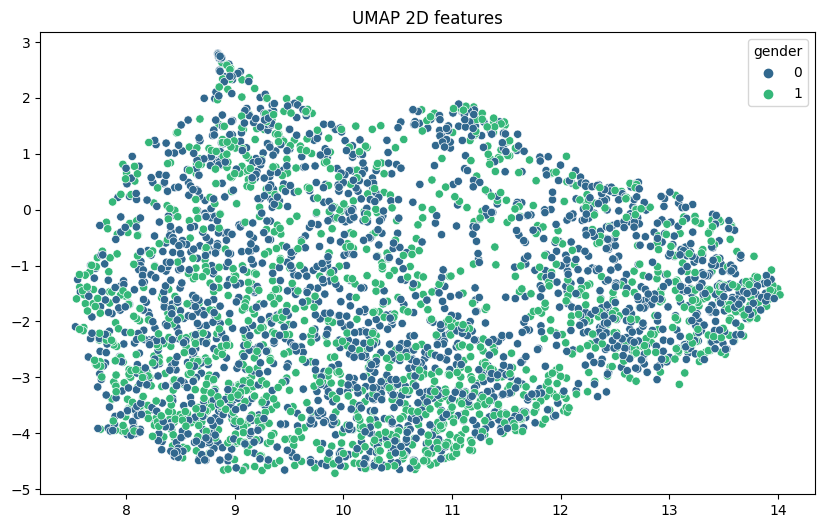

In [55]:
show_2d_emb(reduced_embeddings, inf_test_df["gender"])

# Finaly, classification

In [56]:
X = inf_test_df.drop(columns=["gender"])
y = inf_test_df["gender"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)

In [57]:
classifier = catboost.CatBoostClassifier(
    iterations = 150,
    random_seed = 42,
    verbose = 25,
    train_dir = "CatBoostClassifier",
)

In [58]:
classifier.fit(
    X_train,
    y_train,
)

Learning rate set to 0.084571
0:	learn: 0.6859740	total: 196ms	remaining: 29.2s
25:	learn: 0.5912074	total: 3.69s	remaining: 17.6s
50:	learn: 0.5308643	total: 7.9s	remaining: 15.3s
75:	learn: 0.4747542	total: 12s	remaining: 11.7s
100:	learn: 0.4256956	total: 16.5s	remaining: 8s
125:	learn: 0.3679214	total: 20.8s	remaining: 3.96s
149:	learn: 0.3176831	total: 25.2s	remaining: 0us


In [59]:
classifier.score(X_test, y_test)

0.6069306930693069

**We predicted it well enough!**